<a href="https://colab.research.google.com/github/JhaAkansha/SnowCapMeltAnalysis/blob/main/RS_OEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [30]:
import ee
ee.Authenticate()
ee.Initialize(project='snowcapmelt')

In [52]:
import datetime
import matplotlib.pyplot as plt

# Arctic and Antarctic regions
arctic = ee.Geometry.Point([-45, 69]).buffer(100000)
antarctic = ee.Geometry.Point([-63.5, -73]).buffer(100000)

# NDSI calculation function
def calculate_ndsi(image, green_band, swir_band):
    ndsi = image.normalizedDifference([green_band, swir_band]).rename('NDSI')
    return image.addBands(ndsi)

# Safe median for empty image collections
def safe_median(img_collection):
    size = img_collection.size()
    return ee.Image(ee.Algorithms.If(
        size.eq(0),
        ee.Image(0),  # fallback
        img_collection.median()
    ))

# Main function to compute yearly snow cover
def get_yearly_snow_cover(start_year, end_year, region, platform='Landsat'):
    yearly_snow_stats = []

    for year in range(start_year, end_year + 1):
        start = ee.Date.fromYMD(year, 6, 1)
        end = ee.Date.fromYMD(year, 9, 30)

        if platform == 'Landsat':
            # Filter collections
            l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)

            # Merge all
            merged = l5.merge(l7).merge(l8).merge(l9)

            # Apply NDSI using SR_B3 (green) and SR_B7 (SWIR for Landsat 5/7/8/9)
            processed = merged.map(lambda img: calculate_ndsi(img, 'SR_B3', 'SR_B7'))

        else:
            raise ValueError("Only Landsat supported for now.")

        # Threshold NDSI to get snow
        snow_ndsi = processed.map(lambda img: img.select('NDSI').gt(0.4))

        # Handle empty collection with safe median
        snow_masked = safe_median(snow_ndsi)

        # Multiply snow mask by pixel area
        pixel_area = snow_masked.multiply(ee.Image.pixelArea())

        # Reduce to get total snow-covered area in the region
        stats = pixel_area.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=30,
            maxPixels=1e13
        )

        # Safely extract snow-covered area in km²
        snow_value = ee.Algorithms.If(
            stats.contains('NDSI'),
            ee.Number(stats.get('NDSI')).divide(1e6),
            0
        )

        yearly_snow_stats.append(snow_value)

    return ee.List(yearly_snow_stats)

# === RUNNING FOR ARCTIC AND ANTARCTIC === #
years = list(range(2000, 2025))

print("Calculating Arctic snow cover...")
arctic_snow = get_yearly_snow_cover(2000, 2024, arctic, platform='Landsat')
arctic_area = arctic_snow.getInfo()  # converts ee.List to Python list

print("Calculating Antarctic snow cover...")
antarctic_snow = get_yearly_snow_cover(2000, 2024, antarctic, platform='Landsat')
antarctic_area = antarctic_snow.getInfo()
print("Arctic Snow Area (km²):", arctic_area)
print("Antarctic Snow Area (km²):", antarctic_area)

Calculating Arctic snow cover...
Calculating Antarctic snow cover...
Arctic Snow Area (km²): [11572.203509698358, 11503.952528084865, 11585.101621871609, 9820.419660450183, 11510.572300487427, 9497.523122354682, 11697.684167317771, 11675.53923794847, 11367.186169144188, 11839.847575026024, 12802.946528815413, 12639.477811680375, 12638.870749817104, 13291.380253568883, 12858.674828907719, 12887.095098216576, 13010.43737340373, 12894.582256850588, 13111.571094806384, 12985.64681784532, 12938.138253421708, 12996.438059993205, 12980.568057927965, 12920.876506075194, 13014.287790172728]
Antarctic Snow Area (km²): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


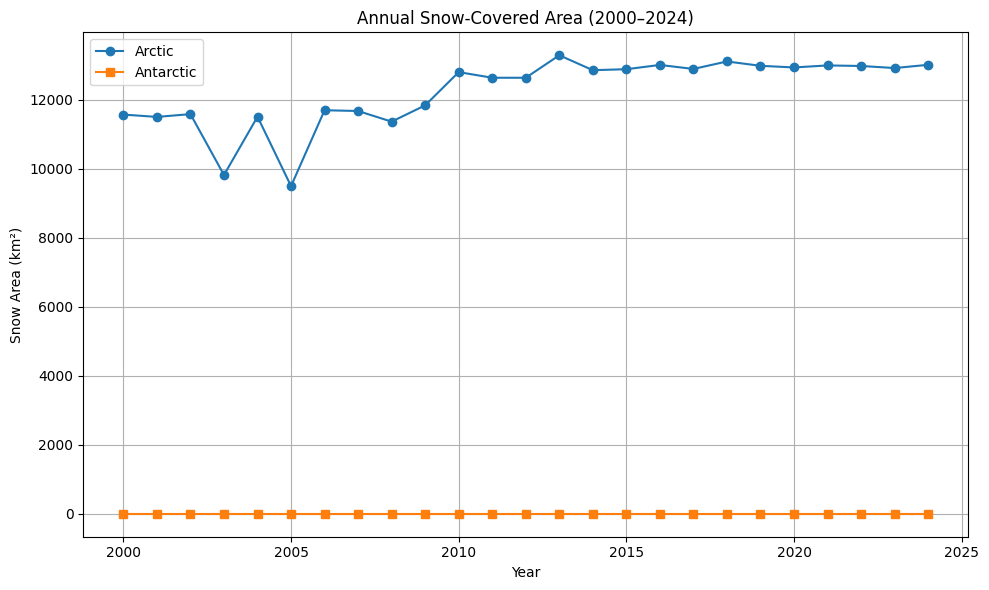

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(years, arctic_area, label='Arctic', marker='o')
plt.plot(years, antarctic_area, label='Antarctic', marker='s')
plt.title("Annual Snow-Covered Area (2000–2024)")
plt.ylabel("Snow Area (km²)")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...
Processing 2023...
Processing 2024...


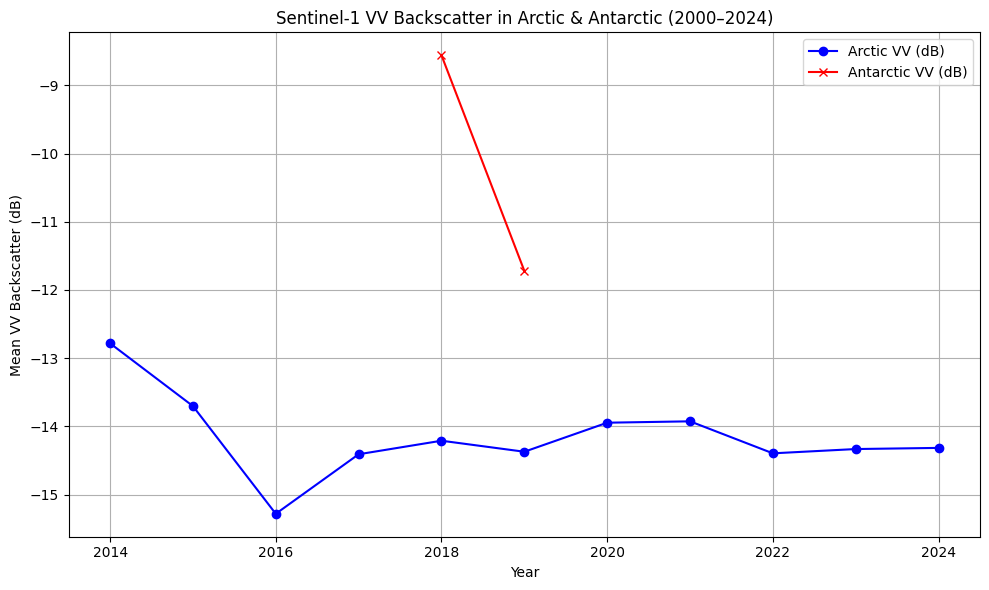

In [65]:

# Define Arctic and Antarctic geometries
arctic = ee.Geometry.Polygon(
    [[[-180, 66.5], [-180, 90], [180, 90], [180, 66.5], [-180, 66.5]]], None, False)
antarctic = ee.Geometry.Polygon(
    [[[-180, -90], [-180, -60], [180, -60], [180, -90], [-180, -90]]], None, False)

#Mean VV backscatter (dB)	Higher = dry snow or ice, Lower = wet/melted

# Years to analyze
years = list(range(2000, 2025))

# Get Sentinel-1 VV backscatter for region and year
def get_s1_vv_mean(region, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .select('VV')

    if s1.size().getInfo() == 0:
        return None

    median = s1.median().clip(region)  # Clip to region
    stats = median.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000,           # coarser resolution to reduce memory
        maxPixels=1e13,
        tileScale=8           # spread out computation to avoid memory limit
    )
    return stats.get('VV').getInfo()

# Store results
arctic_vv = []
antarctic_vv = []

for year in years:
    print(f"Processing {year}...")

    try:
        arctic_val = get_s1_vv_mean(arctic, year)
        arctic_vv.append(arctic_val)
    except Exception as e:
        print(f"  Arctic {year} failed: {e}")
        arctic_vv.append(None)

    try:
        antarctic_val = get_s1_vv_mean(antarctic, year)
        antarctic_vv.append(antarctic_val)
    except Exception as e:
        print(f"  Antarctic {year} failed: {e}")
        antarctic_vv.append(None)

# ---- Plot results ----
plt.figure(figsize=(10, 6))
plt.plot(years, arctic_vv, label='Arctic VV (dB)', marker='o', color='blue')
plt.plot(years, antarctic_vv, label='Antarctic VV (dB)', marker='x', color='red')
plt.title('Sentinel-1 VV Backscatter in Arctic & Antarctic (2000–2024)')
plt.xlabel('Year')
plt.ylabel('Mean VV Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()